In [1]:
import cv2 as cv
import numpy as np

In [2]:
from ProjectPaths import ProjectPaths

ProjectPaths.instance(r"/home/tdjg/Documents/DeepSolaris")

In [3]:
avg_kernel = np.ones((3,3), dtype=np.float32)
avg_kernel /= 9
avg_kernel

array([[0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111]], dtype=float32)

In [4]:
from Datasets import Datasets

In [5]:
ac_dataset = Datasets.datasets()["AcMüDüHo"]
train = ac_dataset[0].images

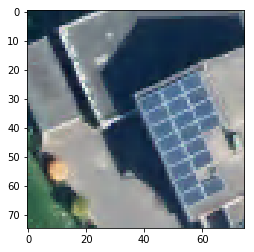

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(train[1][:,:,::-1])

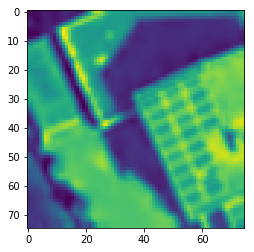

In [7]:
orig = train[1]
dest = cv.filter2D(orig, -1, avg_kernel)
plt.imshow(dest[:,:,0])

In [8]:
def avg_image(image):
    avg_kernel = np.ones((3,3), dtype=np.float32)
    avg_kernel /= 9
    return cv.filter2D(orig, -1, avg_kernel)

In [9]:
orig.shape, dest.shape

((75, 75, 3), (75, 75, 3))

In [10]:
def window_locations(r=2):
    x = [-r, 0, r]
    y = [-r, 0, r]
    mask = np.zeros((1+2*r,1+2*r))
    
    for xc in x:
        for yc in y:
            mask[r + yc, r + xc] = 1.0
    return np.tile(mask,(3,1,1)).T
    
window_mask = window_locations()
window_mask

array([[[1., 1., 1.],
        [0., 0., 0.],
        [1., 1., 1.],
        [0., 0., 0.],
        [1., 1., 1.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[1., 1., 1.],
        [0., 0., 0.],
        [1., 1., 1.],
        [0., 0., 0.],
        [1., 1., 1.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[1., 1., 1.],
        [0., 0., 0.],
        [1., 1., 1.],
        [0., 0., 0.],
        [1., 1., 1.]]])

In [11]:
window_locations(4)

array([[[1., 1., 1.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [1., 1., 1.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [1., 1., 1.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[1., 1., 1.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [1., 1., 1.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [1., 1., 1.]],



In [12]:
a = np.array([[1,2,3,4,5],
             [6,7,8,9,10],
             [11,12,13,14,15],
             [16,17,18,19,20],
             [21,22,23,24,25]])
a * window_mask

ValueError: operands could not be broadcast together with shapes (5,5) (5,5,3) 

In [13]:
def extract_features(image, r=2):
    #grab the spatial dimensions of the image, along with
    # the spatial dimensions of the kernel
    (iH, iW) = image.shape[:2]
    
    kernel = window_locations(r)
    (kH, kW) = kernel.shape[:2]

    # allocate memory for the output image, taking care to
    # "pad" the borders of the input image so the spatial
    # size (i.e., width and height) are not reduced
    pad = (kW - 1) // 2
    image = cv.copyMakeBorder(image, pad, pad, pad, pad,
        cv.BORDER_REPLICATE)
    output = np.zeros((iH, iW, 27), dtype="float32")
    # loop over the input image, "sliding" the kernel across
    # each (x, y)-coordinate from left-to-right and top to
    # bottom
    for y in np.arange(pad, iH + pad):
        for x in np.arange(pad, iW + pad):
            # extract the ROI of the image by extracting the
            # *center* region of the current (x, y)-coordinates
            # dimensions
            roi = image[y - pad:y + pad + 1, x - pad:x + pad + 1]

            # perform the actual selection by taking the
            # element-wise multiplicate between the ROI and
            # the kernel
            k = (roi * kernel)

            # store the convolved value in the output (x,y)-
            # coordinate of the output image
            output[y - pad, x - pad, :] = k[np.nonzero(kernel)]
    
    # return the output image
    return output

In [14]:
avg_output = extract_features(dest)
avg_output.shape

(75, 75, 27)

In [15]:
average = dest
x2_min_avg = (orig - average) * (orig - average);

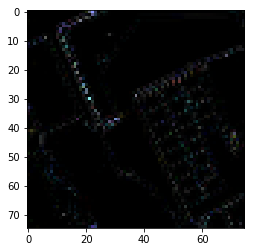

In [16]:
def normalize_image(image):
    return (image - image.min()) / (image.max() - image.min())

#plot the normalized matrix
x2_norm = normalize_image(x2_min_avg)
x2_norm.min(), x2_norm.max()
plt.imshow(x2_norm)

In [17]:
from scipy import ndimage

avg_kernel_3d = np.ones((3, 3, 3), dtype=np.float32)
avg_kernel_3d /= 9

x2_sum_avg = ndimage.convolve(x2_min_avg, avg_kernel_3d) 
x2_sum_avg

array([[[4.06397708e-04, 3.08504492e-04, 2.10611277e-04],
        [2.37639620e-04, 1.84221928e-04, 1.30804236e-04],
        [6.91168600e-05, 6.80411150e-05, 6.69653700e-05],
        ...,
        [7.85562556e-03, 1.35009203e-02, 1.91462151e-02],
        [1.12817162e-02, 1.41307694e-02, 1.69798227e-02],
        [1.64137100e-02, 1.74871396e-02, 1.85605693e-02]],

       [[8.05533951e-04, 6.80847888e-04, 5.56161824e-04],
        [4.95382281e-04, 4.26534301e-04, 3.57686322e-04],
        [1.27375457e-04, 1.18433257e-04, 1.09491057e-04],
        ...,
        [6.27965293e-03, 9.64499871e-03, 1.30103445e-02],
        [8.52124489e-03, 1.07222269e-02, 1.29232088e-02],
        [1.01968583e-02, 1.12275268e-02, 1.22581952e-02]],

       [[4.05913767e-03, 3.63488908e-03, 3.21064049e-03],
        [2.45496058e-03, 2.19116661e-03, 1.92737263e-03],
        [5.06879782e-04, 4.39544473e-04, 3.72209164e-04],
        ...,
        [4.98734200e-03, 6.45022589e-03, 7.91310977e-03],
        [8.43044659e-03, 1.07

In [18]:
std_image = np.sqrt(x2_sum_avg)
std_image
#plt.imshow(normalize_image(std_image))

array([[[0.02015931, 0.0175643 , 0.01451245],
        [0.01541556, 0.01357284, 0.01143697],
        [0.00831366, 0.0082487 , 0.00818324],
        ...,
        [0.08863197, 0.11619346, 0.13836985],
        [0.10621542, 0.11887291, 0.13030665],
        [0.128116  , 0.13223895, 0.13623718]],

       [[0.02838193, 0.02609306, 0.02358308],
        [0.02225718, 0.02065271, 0.0189126 ],
        [0.01128607, 0.0108827 , 0.0104638 ],
        ...,
        [0.07924426, 0.09820895, 0.1140629 ],
        [0.09231059, 0.10354819, 0.11368029],
        [0.10097949, 0.10596002, 0.11071673]],

       [[0.06371136, 0.06029004, 0.05666251],
        [0.04954756, 0.0468099 , 0.04390185],
        [0.02251399, 0.02096532, 0.01929272],
        ...,
        [0.07062112, 0.0803133 , 0.08895566],
        [0.09181746, 0.10384111, 0.11461023],
        [0.09458987, 0.10475681, 0.11402076]],

       ...,

       [[0.0560247 , 0.05534797, 0.05466286],
        [0.05286456, 0.05237037, 0.05187148],
        [0.04879207, 0

In [19]:
def std_image(image):
    average = avg_image(image)
    x2_min_avg = (image - average) * (image - average);
    avg_kernel_3d = np.ones((3, 3, 3), dtype=np.float32)
    avg_kernel_3d /= 9
    conv_image = ndimage.convolve(x2_min_avg, avg_kernel_3d) 
    return np.sqrt(conv_image)

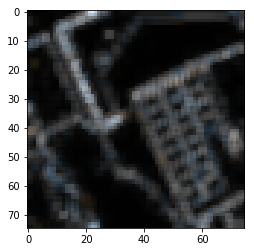

In [20]:
std = std_image(orig)
plt.imshow(normalize_image(std))

In [21]:
std_output = extract_features(std)
std_output.shape

(75, 75, 27)

In [22]:
features = np.concatenate((avg_output, std_output), axis=2)
features.shape

(75, 75, 54)

In [23]:
def get_features(image):
    avg = avg_image(image)
    std = std_image(image)
    
    avg_output2 = extract_features(avg)
    std_output2 = extract_features(std)
    
    avg_output4 = extract_features(avg, 4)
    std_output4 = extract_features(std, 4)
    return np.concatenate((avg_output2, std_output2, avg_output4, std_output4), axis=2)

In [ ]:
def get_features_for(images):
    feature_list = []
    for image in images:
        feature_list.append(get_features(image))
    return np.array(feature_list)
X = get_features_for(ac_dataset[0].images)
X.shape

In [ ]:
y = ac_dataset[0].labels
y.shape

In [ ]:
Xf = X.reshape(3357, 75*75*54*2)

In [ ]:
from sklearn.ensemble import RandomForestClassifier


clf = RandomForestClassifier()
clf.fit(Xf, y)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix


predictions = clf.predict(Xf)
print(classification_report(y, predictions))

In [ ]:
confusion_matrix(y, predictions)

In [ ]:
test_images = ac_dataset[1].images
y_test = ac_dataset[1].labels

In [ ]:
X_test = get_features_for(test_images)

In [ ]:
Xf_test = X_test.reshape(374, 75*75*54*2)
Xf_test.shape

In [ ]:
predictions_test = clf.predict(Xf_test)
print(classification_report(y_test, predictions_test))

In [ ]:
confusion_matrix(y_test, predictions_test)